# Import

In [1]:
!pip install shap
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:
# Podstawowe biblioteki
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import numpy as np

# Biblioteka SHAP
import shap

# Biblioteka do analizy tekstu, oraz do klasyfikacji
import nltk
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Bilbioteka WordCloud
from wordcloud import WordCloud

# Biblioteka do klasyfikacji, oraz odpowiednie modele
from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
# from sklearn.ensemble import RandomForestClassifier
# import xgboost as xgb
# from catboost import CatBoostClassifier

# Biblioteka Transformers
# import transformers
# from transformers import BertTokenizer
# from transformers import TFAutoModel

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/skolanko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/skolanko/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Preprocessing

In [53]:
data = pd.read_csv('Twitter.csv', nrows=70000)
# rename columns
data = data.rename(columns={'clean_text': 'text',"category":"sentiment"})


#zamień sentyment na słowa 1: 'positive', 0: 'neutral', -1: 'negative' a dla innego na neutral
data['sentiment'] = data['sentiment'].replace(1, 'positive')
data['sentiment'] = data['sentiment'].replace(0, 'neutral')
data['sentiment'] = data['sentiment'].replace(-1, 'negative')

valid_sentiments = ["positive", "neutral", "negative"]
data = data[data['sentiment'].isin(valid_sentiments)]

data['text'] = data['text'].astype(str)

# Usunięcie url z treści
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# Usunięcie mentionów
def remove_ment(text):
    mention1 = re.compile(r'@ \w+')
    mention2 = re.compile(r'@\w+')
    text = mention1.sub(r'',text)
    return mention2.sub(r'',text)

# Usunięcie znaków interpunkcyjnych
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation + "“”")
    return text.translate(table)

# Usunięcie html
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Usunięcie emotikonów
def remove_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Znalezienie powtarzających się znaków
def cont_rep_char(text):
    tchr = text.group(0)
    if len(tchr) > 1:
        return tchr[0:2]

# Usunięcie powtarzających się znaków
def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

# Usunięcie stop words ale nie usuwaj not
stop_words = stopwords.words('english')
stop_words = set(stopwords.words('english'))
stop_words.remove('not')
stop_words.remove('no')
stop_words.remove('nor')

def remove_stopwords(text):
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(token)
    return " ".join(tokens)



# funkcja czyszcząca dane

def all_clean(text):
    text = text.lower()
    text = remove_url(text)
    text = remove_ment(text)
    text = remove_punct(text)
    text = remove_emoji(text)
    text = unique_char(cont_rep_char,text)
    text = remove_stopwords(text)
    return text

# print type of data

# Ustawienie wszystkich liter na małe
data['text'] = data['text'].apply(lambda x : x.lower())

# Usunięcie zbędnych elementów
data['text'] = data['text'].apply(lambda x : remove_url(x))
data['text'] = data['text'].apply(lambda x : remove_ment(x))
data['text'] = data['text'].apply(lambda x : remove_punct(x))
data['text'] = data['text'].apply(lambda x : remove_emoji(x))

# Reszta cyszczenia
data['text'] = data['text'].apply(lambda x : unique_char(cont_rep_char,x))
data['text'] = data['text'].apply(lambda x : remove_stopwords(x))

# Usunięcie duplikatów
data = data.drop_duplicates(subset=['text'])

# Usunięcie pustych wartości
data = data.dropna(subset=['text'])

data.to_csv('clearTwitter.csv', index=False)

In [50]:
pd.set_option('display.max_colwidth', None)
data.head()

,text,sentiment
0,modi promised minimum government maximum governance expected begin difficult job reforming state take years get justice state not business exit psus temples,negative
1,talk nonsense continue drama vote modi,neutral
2,say vote modi welcome bjp told rahul main campaigner modi think modi relax,positive
3,asking supporters prefix chowkidar names modi great service confusion read not crustal clear crass filthy nonsensical see abuses coming chowkidars,positive
4,answer among powerful world leader today trump putin modi may,positive


# NLP model

In [5]:
# # Utworenie modelu
# sia = SentimentIntensityAnalyzer()

# # Obliczenie sentymentu
# def compute_sentiment(sentence):
#     result = sia.polarity_scores(sentence)
#     return result['compound'], result['neg'], result['neu'], result['pos']

# # Obliczenie sentymentu dla każdego tweeta
# dataSentiment = data.copy()
# dataSentiment['compound'], dataSentiment['negative'], dataSentiment['neutral'], dataSentiment['positive'] = zip(*data['content'].apply(compute_sentiment))

# # Kategoryzacja sentymentu
# def categorize_sentiment(compound):
#     if compound <= -0.01:
#         return 'negative'
#     elif compound >= 0.01:
#         return 'positive'
#     else:
#         return 'neutral'
# dataSentiment['sentiment'] = dataSentiment['compound'].apply(categorize_sentiment)

# Prezentacja danych
# pd.set_option('display.max_colwidth', None)
# data.sample(5)

# Data presentation

In [13]:
# Przykładowe dane

data.sample(5)

,text,sentiment
120063,lame excuse not acting corrupt stopping modi acting accused augusta westland rahul british citizenship art 370 ram mandir narional heralad ect stopping,negative
138242,stainlessly unselfish modi dynastic politics protectors corruption corrupt finding painful worried protection loot working mutual interest election national interest dynastic interest modi,negative
162415,warns future ‘’ asking ‘not undermine’ pakistan,neutral
154558,modi possible possible modi,neutral
59891,correct like black hole famous satyen boses theory called bosean theory asat technology shd named modian theory forget premier invention making tea gutter gas hence way remaining vote modi vote modi vote modi,positive


Number of positive tweets: 70798


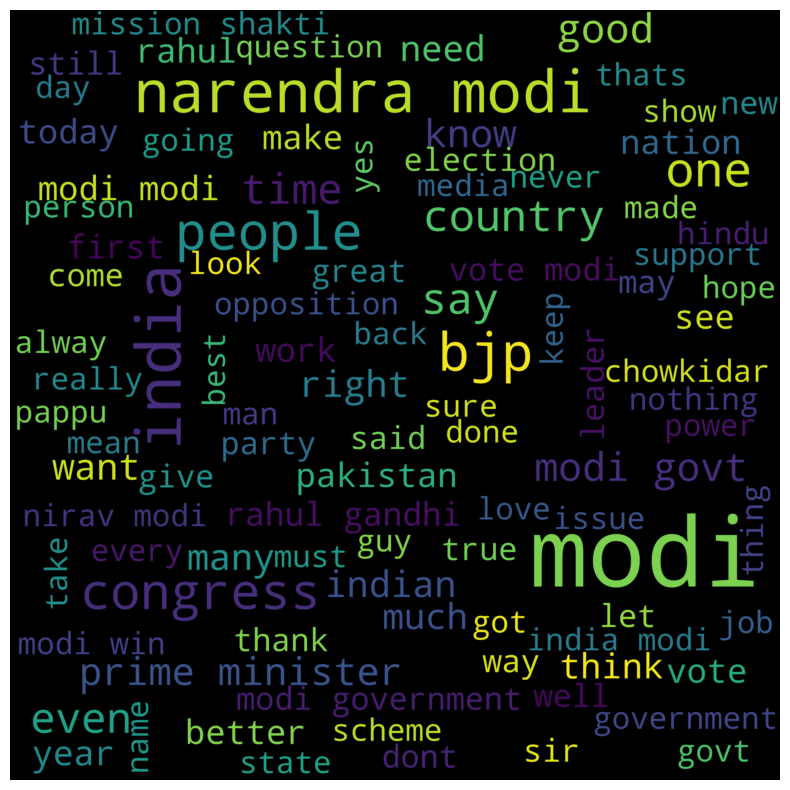

Number of negative tweets: 34908


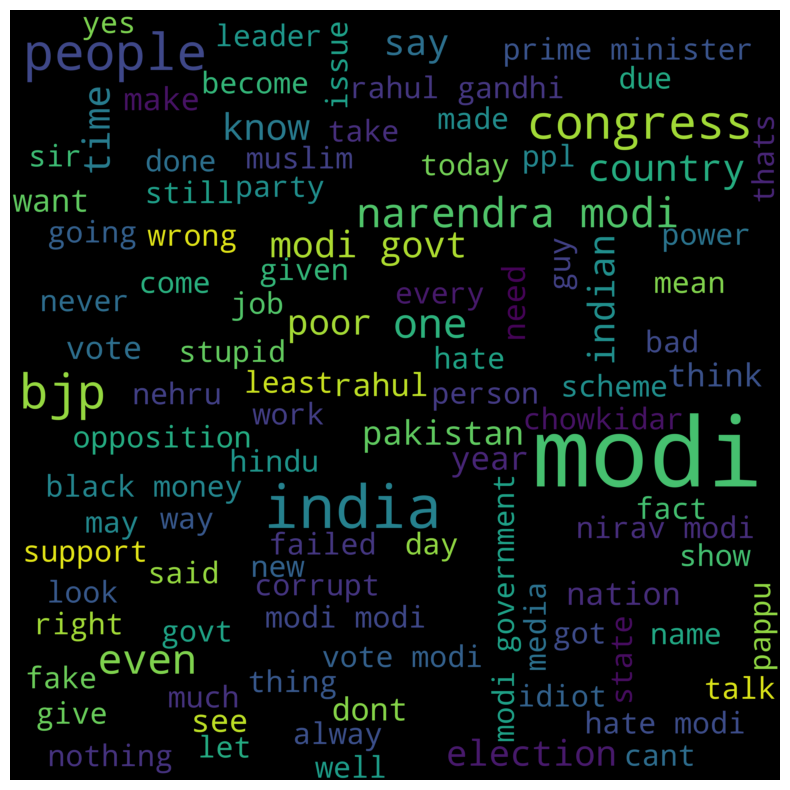

Number of neutral tweets: 52990


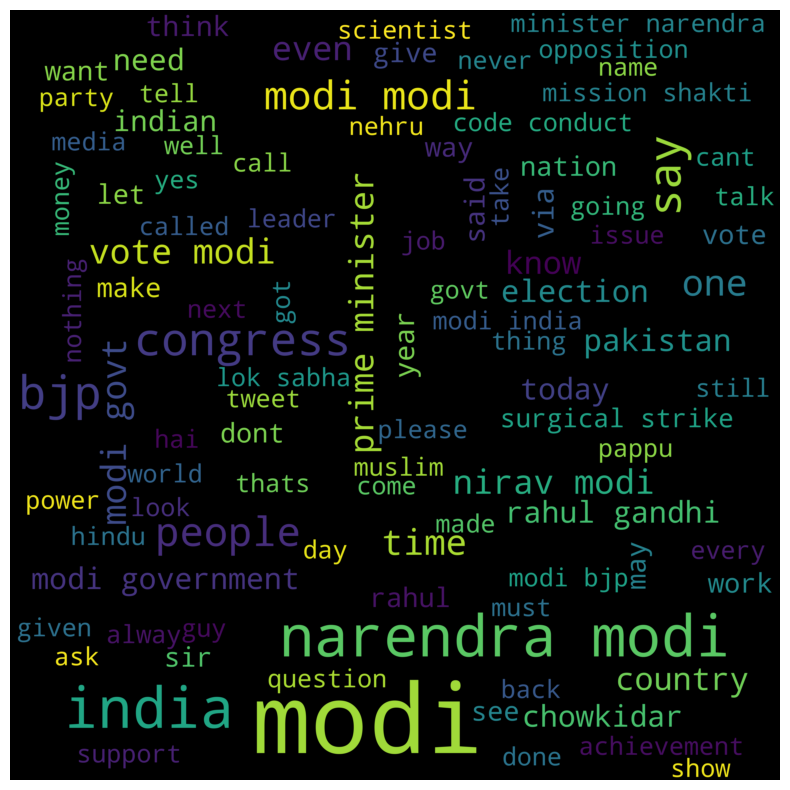

In [14]:
# Prezentacja najczęściej występujących słów w kategoriach sentymentu
for sentiment in ['positive', 'negative', 'neutral']:
    sentiment_data = data[data['sentiment'] == sentiment]
    print(f"Number of {sentiment} tweets: {sentiment_data.shape[0]}")
    word_cloud_text = ' '.join(sentiment_data['text'] )
    wordcloud = WordCloud(
        max_font_size=100,
        max_words=100,
        background_color="black",
        scale=10,
        width=800,
        height=800
    ).generate(word_cloud_text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Model trainning xD

In [56]:
from keras.preprocessing.sequence import pad_sequences
import torch.nn as nn
import torch
from tensorflow.keras.preprocessing.text import Tokenizer
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from transformers.modeling_outputs import SequenceClassifierOutput

vocab_size = 3000
embedding_dim = 1500
num_classes = 3
tokenizer = Tokenizer(num_words = vocab_size, split=' ')
tokenizer.fit_on_texts(data['text'].values)
train_tokens = tokenizer.texts_to_sequences(data['text'].values)
train_tokens = pad_sequences(train_tokens)

#get attention mask
attention_mask = np.where(train_tokens != 0, 1, 0)
attention_mask = torch.tensor(attention_mask, dtype=torch.long)

# # print token and corresponding word
# word_index = tokenizer.word_index
# for word, index in word_index.items():
#     print(f"{word} => {index}")
#     if index == 12:
#         break
# # print sentences dataSentiment['text'] and corresponding token
# for i in range(5):
#     print(f"Sentence: {data['text'][i]}")
#     print(f"Token: {train_tokens[i]}")

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, dtype=torch.float32)
        self.lstm = nn.LSTM(embedding_dim, 64, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :]) 
        x = self.fc(x)
        return x.softmax(dim=1)
    
# # Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print("Device:", device)

model = TextClassificationModel(vocab_size, embedding_dim, num_classes).to(device)

# Przygotowanie danych do modelu
X = train_tokens[:]
y = data['sentiment']

X = np.array(X)
y = np.array(y)

# Zakodowanie etykiet tekstowych na numeryczne
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


num_classes = len(set(y_encoded))
print(set(y_encoded))
print("Number of classes:", num_classes)

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2)

# get attention mask for train and test data
attention_mask_train = attention_mask[X_train]
attention_mask_test = attention_mask[X_test]


# Przygotowanie danych do modelu
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# get attention mask for train and test data


train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
trainAttentionMask = TensorDataset(X_train, attention_mask_train, y_train)
testAttentionMask = TensorDataset(X_test, attention_mask_test, y_test)

# data loader for attention mask


# train_loader = DataLoader(train_dataset, batch_size=2,) #sampler= sampler) # True
# test_loader = DataLoader(test_dataset, batch_size=2,) #sampler= sampler)

print("X_train_tensor shape:", X_train.shape)
print("y_train_tensor shape:", y_train.shape)

# Calculate class weights
class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
sample_weights = class_weights[y_train]

# Print class counts and weights (optional)
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

sampler = WeightedRandomSampler(weights= sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=128,) #sampler= sampler) # True
test_loader = DataLoader(test_dataset, batch_size=128,) #sampler= sampler)

# DataLoader for attention mask
train_loader_attention_mask = DataLoader(trainAttentionMask, batch_size=32,) #sampler= sampler) # True
test_loader_attention_mask = DataLoader(testAttentionMask, batch_size=32,) #sampler= sampler)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(next(iter(test_loader))[0])

def train(dataloader, model, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    total_acc = 0
    total_count = 0
    log_interval = 1000

    for i, (data, targets) in enumerate(dataloader):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        
        total_loss += loss.item()
        total_acc += (output.argmax(1) == targets).sum().item()
        total_count += targets.size(0)
    
    return total_loss / len(dataloader)

def evaluate(dataloader, model, criterion):
    model.eval()
    total_loss = 0
    total_acc = 0 # accuracy
    total_count = 0
    with torch.no_grad():
        for i, (data, targets) in enumerate(dataloader):
            data, targets = data.to(device), targets.to(device)
            output = model(data)
            loss = criterion(output, targets)
            total_loss += loss.item() # sum of loss
            total_acc += (output.argmax(1) == targets).sum().item() #  count correct predictions
            total_count += targets.size(0)
    return total_loss / len(dataloader), total_acc / total_count

## podejście drugier, próbuje inny model wytrenować, z nim powinno być łatwiej dostać wartości shap
def train_transformers(model, iterator, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in iterator:
        optimizer.zero_grad()
        
        inputs, attention_mask, labels = batch
        inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(inputs, attention_mask=attention_mask, labels=labels).to(device)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(iterator)

def evaluate_transformers(model, iterator, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in iterator:
            # unzip 
            inputs, attention_mask, labels = batch
            inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(inputs, attention_mask=attention_mask, labels=labels).to(device)
            loss = outputs.loss
            total_loss += loss.item()
    return total_loss / len(iterator)

Device: cuda
{0, 1, 2}
Number of classes: 3
X_train_tensor shape: torch.Size([54706, 36])
y_train_tensor shape: torch.Size([54706])
Class Counts: [11909 18289 24508]
Class Weights: [8.39701066e-05 5.46776751e-05 4.08030031e-05]
tensor([[   0,    0,    0,  ...,   62,  480, 2186],
        [   0,    0,    0,  ..., 1947,  939,  264],
        [   0,    0,    0,  ...,   72,  843,    2],
        ...,
        [   0,    0,    0,  ..., 2378,  186,   25],
        [   0,    0,    0,  ...,  925,   78, 1630],
        [   0,    0,    0,  ...,    1,    9,  169]])


In [35]:
#test - trenowanie modelu z transformers, na ppierwszym nie działa analiza shap
epochs = 20
# train model and save loss for plotting
from transformers import DistilBertForSequenceClassification
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3).to(device)


train_loss = []
test_loss = []
train_acc = []
test_acc = []
torch.set_grad_enabled(True)

for epoch in range(epochs):
    train_loss.append(train_transformers(model, train_loader_attention_mask, optimizer, criterion, device))
    test_loss.append(evaluate_transformers(model, test_loader_attention_mask, criterion, device))
    print(f"Epoch: {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss[-1]:.4f}")
    print(f"Test Loss: {test_loss[-1]:.4f}")
    print()

# save model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: shape '[64, 1, 1, 28]' is invalid for input of size 50176

In [58]:
epochs = 15
# train model and save loss for plotting

train_loss = []
test_loss = []
train_acc = []
test_acc = []
torch.set_grad_enabled(True)

for epoch in range(1, epochs + 1):
    train_epoch_loss = train(train_loader, model, criterion, optimizer, epoch)
    test_epoch_loss, accuracy = evaluate(test_loader, model, criterion)
    
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
    test_acc.append(accuracy)

    print(f'| End of Epoch: {epoch:02} | Train Loss: {train_epoch_loss:.5f} | Test Accuracy: {accuracy:.5f}')

# save model
torch.save(model.state_dict(), 'model.pth')


| End of Epoch: 01 | Train Loss: 0.62891 | Test Accuracy: 0.86379
| End of Epoch: 02 | Train Loss: 0.62788 | Test Accuracy: 0.86634
| End of Epoch: 03 | Train Loss: 0.62693 | Test Accuracy: 0.86591
| End of Epoch: 04 | Train Loss: 0.62629 | Test Accuracy: 0.86591
| End of Epoch: 05 | Train Loss: 0.62568 | Test Accuracy: 0.86744
| End of Epoch: 06 | Train Loss: 0.62507 | Test Accuracy: 0.86722
| End of Epoch: 07 | Train Loss: 0.62416 | Test Accuracy: 0.86671
| End of Epoch: 08 | Train Loss: 0.62317 | Test Accuracy: 0.86393
| End of Epoch: 09 | Train Loss: 0.62264 | Test Accuracy: 0.86583
| End of Epoch: 10 | Train Loss: 0.62139 | Test Accuracy: 0.86773
| End of Epoch: 11 | Train Loss: 0.62144 | Test Accuracy: 0.86766
| End of Epoch: 12 | Train Loss: 0.62133 | Test Accuracy: 0.86503
| End of Epoch: 13 | Train Loss: 0.62148 | Test Accuracy: 0.86532
| End of Epoch: 14 | Train Loss: 0.62143 | Test Accuracy: 0.86715
| End of Epoch: 15 | Train Loss: 0.62040 | Test Accuracy: 0.86934


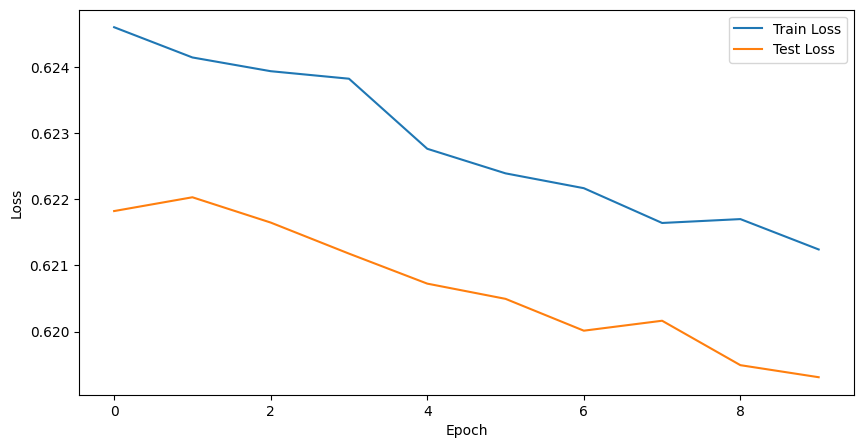

In [11]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# SHAP analysis

In [6]:
# load model from file,
from torch.autograd import Variable
model = TextClassificationModel(vocab_size, embedding_dim, num_classes)
model.load_state_dict(torch.load('model.pth'))
model.to(device)
torch.set_grad_enabled(False)
# device = torch.device("cpu")

tokenizer = Tokenizer(num_words = vocab_size, split=' ')

readTrump = pd.read_csv('realdonaldtrump.csv')    

# Ustawienie wszystkich liter na małe
readTrump['content'] = readTrump['content'].apply(lambda x : x.lower())

# Usunięcie zbędnych elementów
readTrump['content'] = readTrump['content'].apply(lambda x : remove_url(x))
readTrump['content'] = readTrump['content'].apply(lambda x : remove_ment(x))
readTrump['content'] = readTrump['content'].apply(lambda x : remove_punct(x))
readTrump['content'] = readTrump['content'].apply(lambda x : remove_emoji(x))

# Reszta cyszczenia
readTrump['content'] = readTrump['content'].apply(lambda x : unique_char(cont_rep_char,x))
readTrump['content'] = readTrump['content'].apply(lambda x : remove_stopwords(x))

# Usunięcie duplikatów
readTrump = readTrump.drop_duplicates(subset=['content'])

# Usunięcie pustych wartości
readTrump = readTrump.dropna(subset=['content'])
readTrump.drop(["id","link","date","retweets","favorites","mentions","hashtags"], axis=1, inplace=True)

readTrump.to_csv('clearTrump.csv', index=False)
tokenizer.fit_on_texts(data['text'].values)
train_tokens = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(train_tokens)
X = torch.tensor(X, dtype=torch.long).to(device).requires_grad_(False).to(torch.long)

background = X[:100]

expl = shap.DeepExplainer(model, background)
shap_values = expl.shap_values(X)

# # Utworzenie DataLoader
# data_loader = DataLoader(X, batch_size=64)

# f = lambda x: model( Variable( torch.from_numpy(x) ) ).detach().numpy()

# # Pobranie batcha danych
# batch = next(iter(data_loader))
# trumpdata = batch

# # Przygotowanie tła dla SHAP
# background = trumpdata[:100]
# background = background.requires_grad_(False).to(torch.long)

# # Ustawienie SHAP
# explainer = shap.DeepExplainer(f, background)

# # Obliczanie wartości SHAP
# shap_values = explainer.shap_values(X[:1000])

RuntimeError: only Tensors of floating point dtype can require gradients

# Conclusions